<a href="https://colab.research.google.com/github/Grandediw/ml-algorthm/blob/main/Transformers_model_04_AAPL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, MultiHeadAttention, Add, GlobalAveragePooling1D
from tensorflow.keras.utils import plot_model


# Suppress TensorFlow warnings
import warnings
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

# 1. Data Collection and Preprocessing

# Download the data
ticker = 'AAPL'
data = yf.download(ticker, start='2008-01-01', end='2023-10-01')  # Updated end date

# Use additional features
data = data[['Open', 'High', 'Low', 'Close', 'Volume']]

# Handle missing values
data.dropna(inplace=True)

# Feature Engineering: Add technical indicators
data['MA_7'] = data['Close'].rolling(window=7).mean()
data['MA_21'] = data['Close'].rolling(window=21).mean()
data['EMA_7'] = data['Close'].ewm(span=7, adjust=False).mean()
data['EMA_21'] = data['Close'].ewm(span=21, adjust=False).mean()
data['STD_7'] = data['Close'].rolling(window=7).std()
data['STD_21'] = data['Close'].rolling(window=21).std()

# Relative Strength Index (RSI)
delta = data['Close'].diff(1)
delta = delta.dropna()
up = delta.copy()
down = delta.copy()
up[up < 0] = 0
down[down > 0] = 0
time_period = 14
avg_gain = up.rolling(window=time_period).mean()
avg_loss = abs(down.rolling(window=time_period).mean())
rs = avg_gain / avg_loss
rsi = 100.0 - (100.0 / (1.0 + rs))
data['RSI'] = rsi

# Bollinger Bands
data['Upper_band'] = data['MA_21'] + (data['STD_21'] * 2)
data['Lower_band'] = data['MA_21'] - (data['STD_21'] * 2)

# Drop rows with NaN values created by rolling calculations
data.dropna(inplace=True)

# Select features and target
features = data.drop(['Close'], axis=1)
target = data['Close']

# Scale the features and target
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()
scaled_features = feature_scaler.fit_transform(features)
scaled_target = target_scaler.fit_transform(target.values.reshape(-1, 1))

# Prepare sequences
def create_sequences(features, target, time_step):
    X = []
    y = []
    for i in range(time_step, len(features)):
        X.append(features[i - time_step:i])
        y.append(target[i])
    return np.array(X), np.array(y)

# Parameters
time_step = 60
X, y = create_sequences(scaled_features, scaled_target, time_step)

# Split the data into training and testing sets (80% train, 20% test)
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

[*********************100%***********************]  1 of 1 completed


In [2]:
# 2. Build the Transformer Model

# Positional Encoding Function
def positional_encoding(seq_length, d_model):
    angles = np.arange(seq_length)[:, np.newaxis] / np.power(10000, (2 * (np.arange(d_model)[np.newaxis, :] // 2)) / np.float32(d_model))
    pos_encoding = np.zeros((seq_length, d_model))
    pos_encoding[:, 0::2] = np.sin(angles[:, 0::2])  # Apply sin to even indices
    pos_encoding[:, 1::2] = np.cos(angles[:, 1::2])  # Apply cos to odd indices
    return tf.cast(pos_encoding, dtype=tf.float32)

# Transformer Encoder Layer
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Attention and Normalization
    x = LayerNormalization(epsilon=1e-6)(inputs)
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = Dropout(dropout)(x)
    x = Add()([x, inputs])

    # Feed Forward Network
    x_ff = LayerNormalization(epsilon=1e-6)(x)
    x_ff = Dense(ff_dim, activation='relu')(x_ff)
    x_ff = Dropout(dropout)(x_ff)
    x_ff = Dense(inputs.shape[-1])(x_ff)
    x = Add()([x_ff, x])
    return x

# Build the model
input_shape = X_train.shape[1:]
inputs = Input(shape=input_shape)
# Add positional encoding
pos_encoding = positional_encoding(input_shape[0], input_shape[1])
x = inputs + pos_encoding

# Transformer blocks
for _ in range(3):  # Increased number of layers
    x = transformer_encoder(x, head_size=64, num_heads=4, ff_dim=128, dropout=0.1)

x = GlobalAveragePooling1D()(x)
x = Dropout(0.1)(x)
x = Dense(64, activation='relu')(x)
outputs = Dense(1)(x)

model = Model(inputs, outputs)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='mean_squared_error')

# Model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 60, 13)         │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 60, 13)         │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization       │ (None, 60, 13)         │             26 │ add[0][0]              │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ (None, 60, 13)         │         14,093 │ layer_normalization[0… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 60, 13)         │              0 │ multi_head_attention[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 60, 13)         │              0 │ dropout_1[0][0],       │
│                           │                        │                │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_1     │ (None, 60, 13)         │             26 │ add_1[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 60, 128)        │          1,792 │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 60, 128)        │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 60, 13)         │          1,677 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_2 (Add)               │ (None, 60, 13)         │              0 │ dense_1[0][0],         │
│                           │                        │                │ add_1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_2     │ (None, 60, 13)         │             26 │ add_2[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_1    │ (None, 60, 13)         │         14,093 │ layer_normalization_2… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, 60, 13)         │              0 │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_3 (Add)               │ (None, 60, 13)         │              0 │ dropout_4[0][0],       │
│                           │                        │                │ add_2[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_3

 Total params: 53,803 (210.17 KB)

 Trainable params: 53,803 (210.17 KB)

 Non-trainable params: 0 (0.00 B)

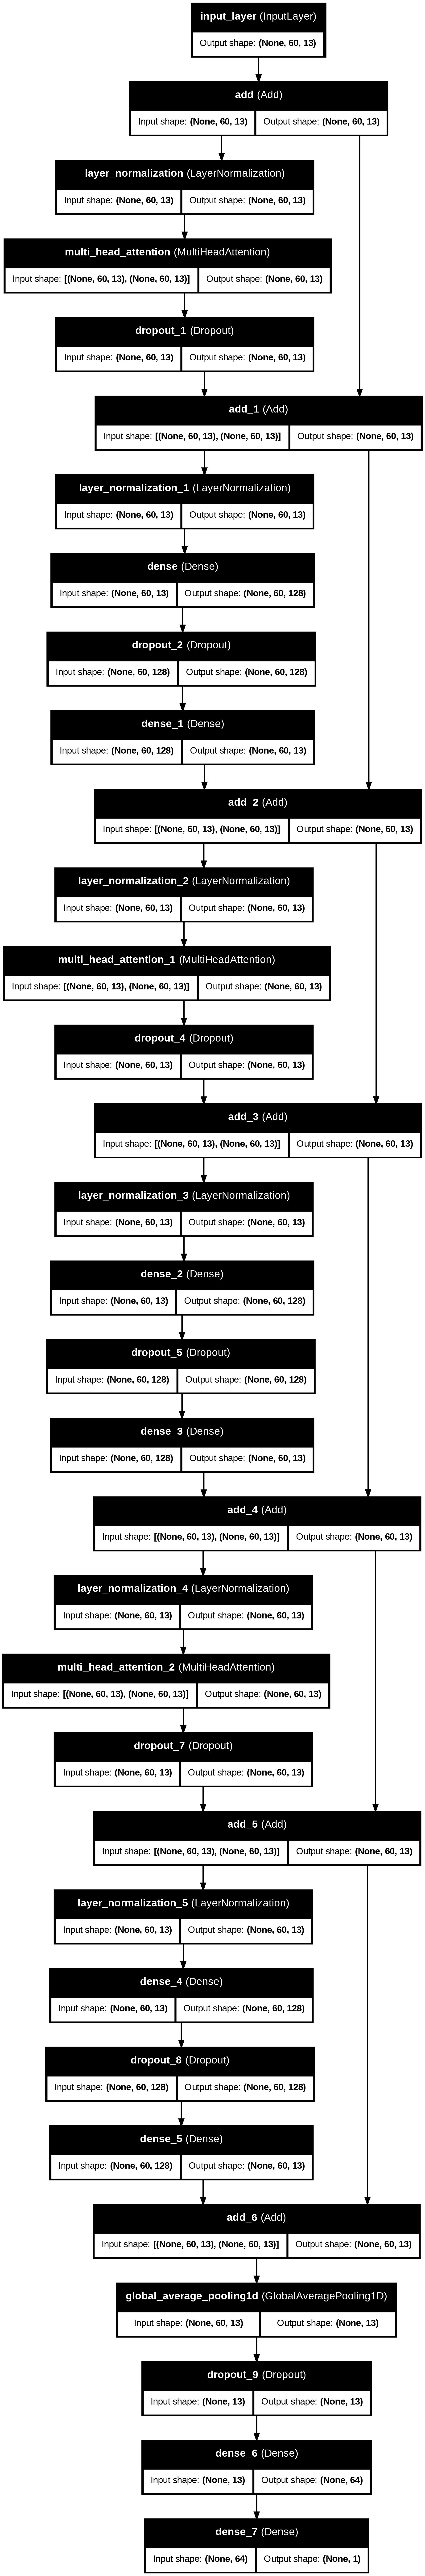

In [3]:
# Save and display the model architecture
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

In [4]:

# 3. Train the Model

# Early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

# 4. Evaluate the Model

# Make predictions
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# Inverse transform the predictions and actual values
train_predictions_inverse = target_scaler.inverse_transform(train_predictions)
y_train_inverse = target_scaler.inverse_transform(y_train)
test_predictions_inverse = target_scaler.inverse_transform(test_predictions)
y_test_inverse = target_scaler.inverse_transform(y_test)

# Compute Evaluation Metrics
def mean_absolute_percentage_error(y_true, y_pred):
    # Avoid division by zero
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_indices = y_true != 0
    y_true_non_zero = y_true[non_zero_indices]
    y_pred_non_zero = y_pred[non_zero_indices]
    mape = np.mean(np.abs((y_true_non_zero - y_pred_non_zero) / y_true_non_zero)) * 100
    return mape

train_rmse = np.sqrt(mean_squared_error(y_train_inverse, train_predictions_inverse))
test_rmse = np.sqrt(mean_squared_error(y_test_inverse, test_predictions_inverse))
train_mae = mean_absolute_error(y_train_inverse, train_predictions_inverse)
test_mae = mean_absolute_error(y_test_inverse, test_predictions_inverse)
train_mape = mean_absolute_percentage_error(y_train_inverse, train_predictions_inverse)
test_mape = mean_absolute_percentage_error(y_test_inverse, test_predictions_inverse)

print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Train MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Train MAPE: {train_mape}%")
print(f"Test MAPE: {test_mape}%")

Epoch 1/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 24s 154ms/step - loss: 0.0346 - val_loss: 0.1624
Epoch 2/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 20s 146ms/step - loss: 0.0042 - val_loss: 0.0849
Epoch 3/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 21s 152ms/step - loss: 0.0029 - val_loss: 0.0598
Epoch 4/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 20s 147ms/step - loss: 0.0025 - val_loss: 0.0378
Epoch 5/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 21s 157ms/step - loss: 0.0019 - val_loss: 0.0245
Epoch 6/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 27s 229ms/step - loss: 0.0017 - val_loss: 0.0101
Epoch 7/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 19s 188ms/step - loss: 0.0013 - val_loss: 0.0077
Epoch 8/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 15s 151ms/step - loss: 0.0011 - val_loss: 0.0043
Epoch 9/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 14s 146ms/step - loss: 0.0010 - val_loss: 0.0032
Epoch 10/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 20s 146ms/step - loss: 9.5616e-04 - val_loss: 0.0029
Epoch 11/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 15s 149ms/step - loss: 9.4692e-04 - val_loss: 0.0028
Epoch 12/20
98/98 ━━━━━━━━━━━━━━━

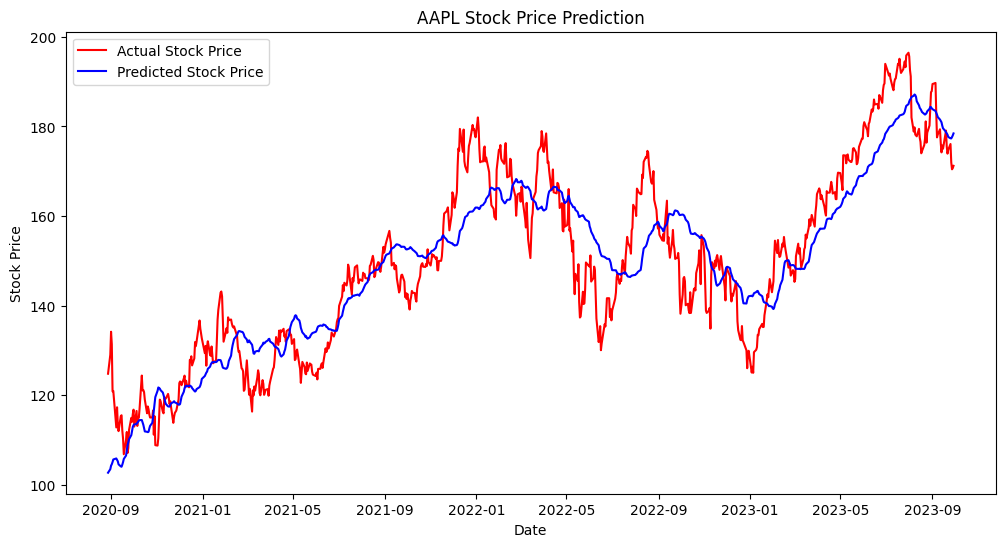

In [7]:
# 5. Visualize the Results

# Prepare dates for plotting
dates = data.index[-len(y_test_inverse):]

plt.figure(figsize=(12, 6))
plt.plot(dates, y_test_inverse.flatten(), color='red', label='Actual Stock Price')
plt.plot(dates, test_predictions_inverse.flatten(), color='blue', label='Predicted Stock Price')
plt.title('AAPL Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

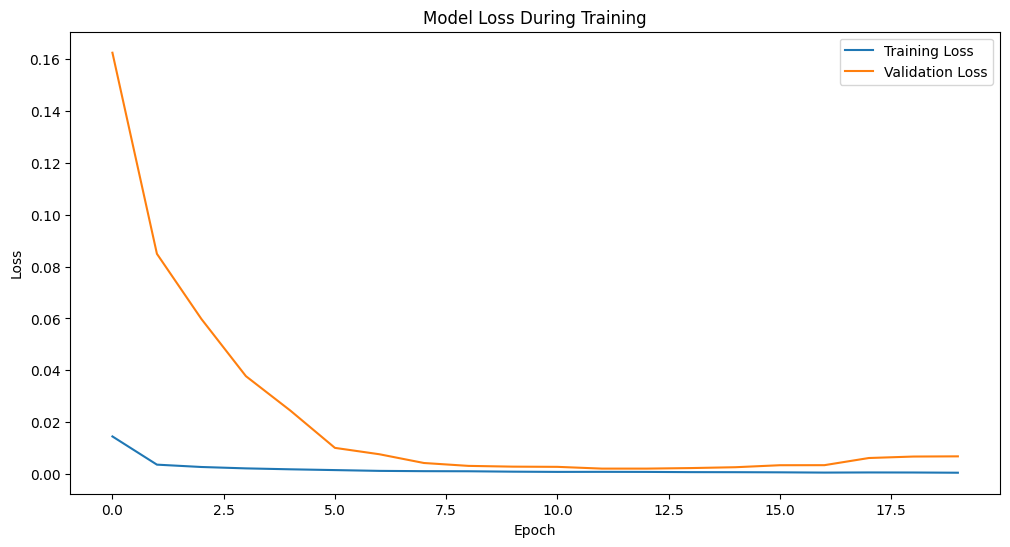

In [6]:

# Plot Training and Validation Loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()